# Introduction to text classification

Text classification is becoming a common solution to many problems in industry today including [chatbots](https://en.wikipedia.org/wiki/Chatbot), [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis), [recommendations](https://en.wikipedia.org/wiki/Recommender_system), etc. This article will focus on utilizing [scikit-learn](http://scikit-learn.org), a mature machine library in Python to create models that will classify text.

The data we will be using today is publicly available [reddit](http://reddit.com/) data available [here in a Google BigQuery repository](https://bigquery.cloud.google.com/dataset/fh-bigquery:reddit_posts?pli=1). For today's problem, we're interested in being able to take the "title" of a post and predict which subreddit that post came from. If you are unfamiliar with reddit and want to know what I'm talking about, head on to [reddit](https://www.reddit.com/) to find out! We are going to be limiting our categories to 16 popular computer science/software development related subreddits because it gives us a relatively non-trivial number of classes and also gives us related categories that are going to be challenging to separate.

The data used here is provided in this page's [GitHub repository](https://github.com/victorkwak/FastTextEnsemble) so no need to separately download the data to follow this tutorial. Using Google Cloud to download data is out of the scope of this article.

## Setup

I recommend downloading Python 3 [Anaconda](https://www.anaconda.com/download/) as it's the easiest way I know of to install everything need to follow this tutorial.

## Reading in the data

[Considered one of the most important tools available to the data science communities](https://qz.com/1126615/the-story-of-the-most-important-tool-in-data-science/), [Pandas](https://pandas.pydata.org/) makes data tasks such as cleaning, querying, filtering, etc. fast and simple (relatively) thanks to its data built-in data structures and functions. For those familiar with R, think of Pandas as a Python version of R dataframes. Today, we will be reading in all the data into Pandas DataFrames. [`sample()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html) gives you a random sample and so when you run this code, the output will likely look very different. Don't worry! That's normal! For more consistency, you can also use [`head()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html) or [`tail()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.tail.html) to look at the first $n$ or last $n$ rows of data, but I prefer seeing random samples.

In [1]:
import pandas as pd

# loads the data into a DataFrame object
data = pd.read_csv('data/reddit.csv')

print('Number of unique subreddits in the dataset:', len(data['subreddit'].unique()))
print('Number of title posts in dataset:', data.shape[0])

# sample() selects a random row or rows if an integer is passed in.
data.sample(10)

Number of unique subreddits in the dataset: 16
Number of title posts in dataset: 43587


title  score  \
12670               Google hardware is no longer a hobby    472   
26405  Setting up Python on Windows and Installing a ...      7   
21623                                    Learn .net core     13   
30867  Solving Guerrilla Sections Problems of CS61B(d...     19   
3453                                            React 16    381   
3330   React.js tutorial for beginner. Learn to crawl...    248   
38027                             Siri getting technical   1014   
37530  Saw this in r/linux thought people here might ...    667   
32587                    Beware of interviewing at Karat    441   
37775  A volume slider only the greatest programmers ...   1375   

               subreddit  
12670            Android  
26405        learnpython  
21623   learnprogramming  
30867  cscareerquestions  
3453          javascript  
3330          javascript  
38027    ProgrammerHumor  
37530    ProgrammerHumor  
32587  cscareerquestions  
37775    ProgrammerHumor

## Splitting up the data

We will be splitting our data into input $X$ and output $y$. In our case, the input data $X$ are the reddit title posts and the labels $y$ are the subreddits those posts came from. 

In order to test our model after we've trained it, it's incredibly important that we have a test dataset that the model has never seen before because otherwise, you cannot be sure that your model hasn't just memorized what you've shown it and isn't good at generalizing to new data. It's kind of like tests as school where the teacher gives you slightly different questions from your homework to make sure you actually learned the material and not just memorized the homework answers hoping those are also on the test. For more information, here is a Wikipedia article on [overfitting](https://en.wikipedia.org/wiki/Overfitting).

We will be splitting up our data into training (70%) and test (30%). To do this, we will be using scikit-learn's [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. `test_size=0.3` means that 30% of all the data will be allotted to the training set. `random_state=17` is to set the random seed for consistent splits (feel free to change however you like). 

In [2]:
from sklearn.model_selection import train_test_split

X = data['title']
y = data['subreddit']

# The parameter "test_size" is a floating [0.0, 1.0] representing percentage
# or an integer for setting a fixed test set size.
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X, y, test_size=0.3, random_state=17)

print('Training set size:', X_train_text.shape[0])
print('Test set size:', X_test_text.shape[0])

Training set size: 30510
Test set size: 13077


In [3]:
X.sample(10)

12840    Essential Phone Durability Test - Titanium Scr...
893      Purism Collaborates with Cryptocurrency Monero...
19107    Installing Linux on an old PC, I'm having prob...
40498    Windows boots to black screen after signing in...
43272    Is Kite taking over open source tools and inje...
27450                          Port 22: Connection Refused
7043                                             ARP alias
25278    Thoughts on storing interface strings as varia...
26028                       How to automate my reddit bot?
32800    High school junior (now senior) here, should I...
Name: title, dtype: object

In [4]:
y.sample(10)

10752            Android
13219            Android
41703         hackernews
2735          javascript
15122             webdev
6535          networking
28319     linuxquestions
15348             webdev
37483    ProgrammerHumor
23800        learnpython
Name: subreddit, dtype: object

## Creating numerical data from text

### Mapping string labels to numbers

In order for scikit-learn to process the data, everything including the class labels (subreddits in this case) need to be converted to numerical values. scikit-learn's [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) allows you to map unique class labels to numbers and transform them back to their original string values if you want to later on. Basically, it's a hashmap with some added functionality.

Please note the usage of the `fit()` and `transform()` functions. This type of syntax is common throughout scikit-learn's API. In this case, `fit()` will identify the unique values in `data['subreddit']` and assign values to them. `transform()` will use this mapping and convert labels to numbers.

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data['subreddit'])

y_train = label_encoder.transform(y_train_text)
y_test = label_encoder.transform(y_test_text)

print('Before encoding:\n', y_train_text.head(5), sep='')
print('\nAfter encoding:\n', y_train[0:5], sep='')

Before encoding:
21158     androiddev
11006        Android
14923         webdev
25201    learnpython
19402    linux4noobs
Name: subreddit, dtype: object

After encoding:
[ 3  0 14  9 11]


### Term Frequency - Inverse Document Frequency

There are several ways to convert textual data into numerical form or more specifically, vectors. Today, we will be using a technique called $tfidf$ (Term Frequency - Inverse Document Frequency) where each word is assigned a score based on how many times the word shows up _per_ input (increases score) versus how many times the word shows up in the _entire_ dataset (decreases score). These values are used to represent sentences as vectors. Mathematically:

$$ tfidf(t, d, D) = tf(t, d) \times idf(t, D)$$ where $t = $ term, $d = $ document, and $D = $ _all_ documents. [More here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

In order to vectorize our text, we will be using scikit-learn's [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). It comes with a lot of useful default arguments for its many parameters such as choosing to lowercase all the strings so that things like "The" and "the" aren't treated as different. Some parameters are better if tuned, however, and we will focus on two parameters : `ngram_range` and `stop_words`.

#### N-Grams
[N-grams](https://en.wikipedia.org/wiki/N-gram) refer to contiguous sets of tokens. In English, these tokens can be at the character level or the word level. We'll be using word-level n-grams today so let's see what that look like:

Example sentence: "The dog jumped"
* Unigrams(1-grams): ["The", "dog", "jumped"]
* Bigrams (2-grams): ["The dog", "dog jumped"]
* Trigrams (3-grams): ["The dog jumped"]

n-grams are useful for when you want to look for popular contiguous word. For instance, for our dataset using computer science subreddits, "programming" and "language" will likely appear frequently together and "programming language" will impart more meaning to an ML model than treating those words as separate things. In the code below, `ngram_range=(1,2)` means to take both the unigrams and bigrams of sentences into consideration. Why did I pick `(1,2)` and not some other range? I tested other ranges and found that `(1,2)` works well for this dataset.

#### Stop words
[Stop words](https://en.wikipedia.org/wiki/Stop_words) are words that are very unlikely to impart a lot of predictive power and may just add noise to the data. Some common stop words are words like "the", "a", "and", etc. _Stop words are often use case-specific_ and "the", "a" and "and" may in some cases impart lots of predictive power. Figuring out all the good stop words for the all datasets is probably not feasible and so people have come up with lists that are considered good in many situations. In the code below, `stop_words='english'` means that words in scikit learn's default English stop words list will be filtered out. You can easily omit the stop words argument to not filter out any stop words. Try it and see if it works any better! To have a look at scikit-learn's complete list of English stop words, [look here](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py).

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
vectorizer.fit(X_train_text)
X_train = vectorizer.transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

## Models, testing, and tuning

### Support Vector Machine

Although currently [Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_network) are considered the new gold standard for NLP problems, [Support Vector Machines (SVMs)](https://en.wikipedia.org/wiki/Support_vector_machine) perform surprisingly well and depending on the kind and how much data is available, can perform better than some neural networks. They are also easier to train and very fast at inference (complicated Neural Networks can take a long to not only train but also be slow at inference).

### Cross-Validation
[Cross-Validation](https://en.wikipedia.org/wiki/Cross-validation_&28statistics%29) is a popular way to validate that your model is performing well and to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting). Today, we will be using a popular type of cross-validation technique called "K-fold Cross-validation." In K-fold CV, you are randomly splitting your **training** data into $k$ number of chunks. You will then iterate $k$ many times, selecting _one_ of those chunks to be the "test" set for that iteration, and use the rest as training data. You take the average scores from all iterations as your cross-validation score. This validation step is where you will tune your model hyperparameters. 

**Warning:** Cross-validation can become very expensive. You are training a model $k$ different times. It is also _very_ important to know **not** to use your _test_ data during the training and tuning process.
<img src="images/K-fold_cross_validation_EN.jpg">

scikit-learn comes with a function called [`cross_validate()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) which performs the steps described above and returns a dictionary with the keys `test_score`, `train_score`, `fit_time`, and `score_time`. Today, we are only interested in `test_score` to determine model performance.

The following code shows how `cross_validate()` works using scikit-learn's [`LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) using just the default parameters. We are getting a list of scores (in this case) and so we use numpy's `mean()` function to obtain the average.

In [7]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate

svm = LinearSVC()
scores = cross_validate(svm, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)['test_score']
print('5-fold CV score:', np.mean(scores))

5-fold CV score: 0.6325803038580748


Next, we will try and tune the regularization strength parameter for the SVM, `C`. numpy's `linspace` allows you to define a range and number to generate and it will generate an array of evenly spaced numbers for you to use. For example 

`np.linspace(0.01, 1.0, num=20)`

results in 

`array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])`
       
We will pass in these values as potential `C` values to see which value gives us the best CV score.

**Warning!**
As mentioned earlier, cross-validation can become very expensive. When performing a parameter search like we are doing now, we are essentially training $k$ different models for every parameter we try. In this example, we are trying 20 different values of `C` on a 5-fold cross-validation test. That means we are training $20 \times 5 = 100$ models in order to assess which parameter `C` is likely to work best.

Best Cross-validation accuracy: 0.6335312534885879
Best C: 0.791578947368421


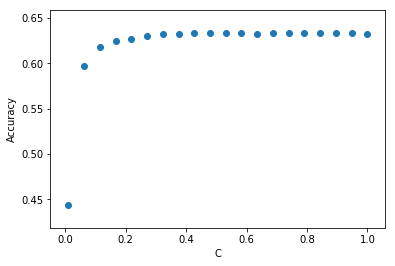

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

mean_scores = []
c_vals = np.linspace(0.01, 1.0, num=20)
for c in c_vals:
    svm = LinearSVC(C=c, max_iter=1000)
    score = cross_validate(svm, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)['test_score']
    mean_scores.append(np.mean(score))
    
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.scatter(x=c_vals, y=mean_scores)
best_c = c_vals[np.argmax(mean_scores)]
print('Best Cross-validation accuracy:', np.max(mean_scores))
print('Best C:', best_c)

But what if you have multiple parameters you want to tune? What if you just don't like writing for-loops? Enter `GridSearchCV`, an expensive and exhaustive way to search for ideal parameters. It basically does the same thing as the previous code except you don't need to write multiple loops for multiple parameters. You also don't need to retrain your model after you've found the best parameters as `GridSearchCV` will save the best performing model and parameters.

All you need to do is create a dictionary with the parameters you're wanting to try. In our case, we will use the same `C` values as last time, but also try the two different loss functions available to `LinearSVC`. Again, this can get expensive. Last time, we trained $100$ models. This time, we're training $2 \times 20 \times 5 = 200$ models to see which parameters work well.

In [9]:
from sklearn.model_selection import GridSearchCV

params = {
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.1, 1.0, num=20)
}
svm_optimized = GridSearchCV(LinearSVC(), params, scoring='accuracy', n_jobs=-1, cv=5)
svm_optimized.fit(X_train, y_train)
print(svm_optimized.best_params_)
print(svm_optimized.best_score_)

{'loss': 'squared_hinge', 'C': 0.5263157894736842}
0.6335299901671583


63% is, admittedly, not that great a number. But honestly, it's a hard task. I don't know that a well-versed human would be able to read these titles and be great at predicting which titles came from which subreddits, especially given that they're similar in subject. I imagine that with less similar subreddits, your accuracy should get much higher. There are other things you can try tuning such as limiting the number of tokens the `TfidfVectorizer` keeps track of and usage stop words that work better than the default list. Using more robust models such as Neural Networks _might_ get us higher performance, but that's out of scope of this tutorial. Maybe in the next one!

With all that, let's finally test our model performance on our test set. If all went well, the cross-validated score should be very close to the test accuracy.

In [10]:
from sklearn.metrics import accuracy_score

y_hat = svm_optimized.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_hat))

Test accuracy: 0.6470138410950523


## Actually using the model

Now that we've trained and tuned and trained and tuned our model, how do we use it on new data (text, in our case)? We first need to vectorize the text using $tfidf$ and then put that through the model. Enter [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): this object allows you to define the transformations your data needs to go through before classification in one go. 

Usage is quite simple: 
1. Define a list of stuff (string, object) for your data to go through
2. Pass that into `Pipeline`
3. Profit

In [11]:
from sklearn.pipeline import Pipeline

steps = [('tf-idf', vectorizer), ('svm', svm_optimized)]
pipeline = Pipeline(steps)
pipeline.predict(X_test_text) # X_test_text is raw text

array([ 9, 12,  0, ..., 14,  6, 10])

Want to try your own strings? Just pass them into the `pipeline`.

In [12]:
custom_string = "I'm a programmer. How do I make more money?"
prediction = pipeline.predict([custom_string]) # predict() takes in a list
print('Model Prediction:', prediction)
print('Subreddit:', label_encoder.inverse_transform(prediction))

Model Prediction: [4]
Subreddit: ['cscareerquestions']


/home/victorkwak/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Please don't mind the warning. This [StackOverflow](https://stackoverflow.com/questions/48687375/deprecation-error-in-sklearn-about-empty-array-without-any-empty-array-in-my-cod) post explains it well, but without digging into the details, know that it can safely be ignored and will probably be fixed in a later version (at the time of writing this, I am using scikit-learn v0.19.1). 

# Conclusion

In this article, we covered the basics of text classification using scikit-learn. To recap, we:
1. Loaded our data into Pandas DataFrames and split it into input data $X$ and output label $y$. 
2. The data was split into training and test sets in order to later properly validate the performance of our model.
3. Converted all our text data into $tfidf$ vectors and our labels into numerical values.
4. Trained and tuned a support vector machine classifier.
5. Created a Pipeline object to perform transformation and classification in one step.

Thanks for reading! I hope you found the information useful.